In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataco-smart-supply-chain-for-big-data-analysis/tokenized_access_logs.csv
/kaggle/input/dataco-smart-supply-chain-for-big-data-analysis/DataCoSupplyChainDataset.csv
/kaggle/input/dataco-smart-supply-chain-for-big-data-analysis/DescriptionDataCoSupplyChain.csv


# Masukkan Libary

In [2]:
import pandas as pd
import torch
import warnings
warnings.filterwarnings("ignore")
import pickle
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [3]:
!ls /kaggle/input/dataco-smart-supply-chain-for-big-data-analysis/


DataCoSupplyChainDataset.csv	  tokenized_access_logs.csv
DescriptionDataCoSupplyChain.csv


# Memasukkan dataset 

In [4]:
df = pd.read_csv("/kaggle/input/dataco-smart-supply-chain-for-big-data-analysis/DataCoSupplyChainDataset.csv", encoding='ISO-8859-1')
df.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Id,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Customer Id,order date (DateOrders),Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.0,2,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,20755,1/31/2018 22:56,77202,1360,13.110000,0.04,180517,327.75,0.29,1,327.75,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Irene,19492,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.0,2,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,19492,1/13/2018 12:27,75939,1360,16.389999,0.05,179254,327.75,-0.80,1,327.75,311.359985,-249.089996,South Asia,Rajastán,PENDING,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,XXXXXXXXX,Gillian,19491,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125.0,2,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,19491,1/13/2018 12:06,75938,1360,18.030001,0.06,179253,327.75,-0.80,1,327.75,309.720001,-247.779999,South Asia,Rajastán,CLOSED,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,EE. UU.,XXXXXXXXX,Tana,19490,Tate,XXXXXXXXX,Home Office,CA,3200 Amber Bend,90027.0,2,Fitness,34.125946,-118.291016,Pacific Asia,Townsville,Australia,19490,1/13/2018 11:45,75937,1360,22.940001,0.07,179252,327.75,0.08,1,327.75,304.809998,22.860001,Oceania,Queensland,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Orli,19489,Hendricks,XXXXXXXXX,Corporate,PR,8671 Iron Anchor Corners,725.0,2,Fitness,18.253769,-66.037048,Pacific Asia,Townsville,Australia,19489,1/13/2018 11:24,75936,1360,29.500000,0.09,179251,327.75,0.45,1,327.75,298.250000,134.210007,Oceania,Queensland,PENDING_PAYMENT,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


Keterangan tiap kolom dataset

1. **Type**: Jenis transaksi yang dilakukan.
2. **Days for shipping (real)**: Hari pengiriman aktual produk yang dibeli.
3. **Days for shipment (scheduled)**: Hari pengiriman yang dijadwalkan untuk produk yang dibeli.
4. **Benefit per order**: Pendapatan per pesanan yang dilakukan.
5. **Sales per customer**: Total penjualan per pelanggan.
6. **Delivery Status**: Status pengiriman pesanan (misalnya, pengiriman awal, tertunda, atau selesai).
7. **Late delivery risk**: Variabel kategoris yang menunjukkan apakah ada risiko keterlambatan pengiriman.
8. **Category Id**: Kode kategori produk.
9. **Category Name**: Deskripsi kategori produk.
10. **Customer City**: Kota tempat pelanggan melakukan pembelian.
11. **Customer Country**: Negara tempat pelanggan melakukan pembelian.
12. **Customer Email**: Email pelanggan.
13. **Customer Fname**: Nama depan pelanggan.
14. **Customer Id**: ID pelanggan.
15. **Customer Lname**: Nama belakang pelanggan.
16. **Customer Password**: Kata sandi pelanggan yang telah dimask.
17. **Customer Segment**: Tipe pelanggan (misalnya, Konsumen, Korporat, dll.).
18. **Customer State**: Negara bagian tempat toko yang menerima pembelian berada.
19. **Customer Street**: Jalan tempat toko yang menerima pembelian berada.
20. **Customer Zipcode**: Kode pos pelanggan.
21. **Department Id**: Kode departemen toko.
22. **Department Name**: Nama departemen toko.
23. **Latitude**: Garis lintang lokasi toko.
24. **Longitude**: Garis bujur lokasi toko.
25. **Market**: Pasar tempat pesanan dikirim (misalnya, Afrika, Asia).
26. **Order City**: Kota tujuan pesanan.
27. **Order Country**: Negara tujuan pesanan.
28. **Order Customer Id**: Kode pesanan pelanggan.
29. **Order date (DateOrders)**: Tanggal pesanan dibuat.
30. **Order Id**: Kode pesanan.
31. **Order Item Cardprod Id**: Kode produk yang dihasilkan melalui pembaca RFID.
32. **Order Item Discount**: Nilai diskon item pesanan.
33. **Order Item Discount Rate**: Persentase diskon item pesanan.
34. **Order Item Id**: Kode item pesanan.
35. **Order Item Product Price**: Harga produk tanpa diskon.
36. **Order Item Profit Ratio**: Rasio keuntungan item pesanan.
37. **Order Item Quantity**: Jumlah produk per pesanan.
38. **Sales**: Nilai penjualan.
39. **Order Item Total**: Jumlah total per pesanan.
40. **Order Profit Per Order**: Keuntungan per pesanan.
41. **Order Region**: Wilayah dunia tempat pesanan dikirim.
42. **Order State**: Negara bagian tempat pesanan dikirim.
43. **Order Status**: Status pesanan (misalnya, COMPLETE, PENDING, CLOSED).
44. **Product Card Id**: Kode produk.
45. **Product Category Id**: Kode kategori produk.
46. **Product Description**: Deskripsi produk.
47. **Product Image**: Tautan untuk mengunjungi dan membeli produk.
48. **Product Name**: Nama produk.
49. **Product Price**: Harga produk.
50. **Product Status**: Status stok produk (1: tidak tersedia, 0: tersedia).
51. **Shipping date (DateOrders)**: Tanggal dan waktu pengiriman aktual.
52. **Shipping Mode**: Mode pengiriman yang digunakan (misalnya, Standar, Ekspres).








# Preprocessing data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  object 
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Sales per customer             180519 non-null  float64
 5   Delivery Status                180519 non-null  object 
 6   Late_delivery_risk             180519 non-null  int64  
 7   Category Id                    180519 non-null  int64  
 8   Category Name                  180519 non-null  object 
 9   Customer City                  180519 non-null  object 
 10  Customer Country               180519 non-null  object 
 11  Customer Email                 180519 non-null  object 
 12  Customer Fname                

In [6]:
df.isnull().sum().to_frame().sort_values(by = [0], ascending=False).T

,Product Description,Order Zipcode,Customer Lname,Customer Zipcode,Type,Order Profit Per Order,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Region,order date (DateOrders),Order State,Order Status,Product Card Id,Product Category Id,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Order Id,Order Country,Order Customer Id,Customer Fname,Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Email,Customer Id,Days for shipping (real),Customer Password,Customer Segment,Customer State,Customer Street,Department Id,Department Name,Latitude,Longitude,Market,Order City,Shipping Mode
0,180519,155679,8,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
df.isna().sum()

Type                                  0
Days for shipping (real)              0
Days for shipment (scheduled)         0
Benefit per order                     0
Sales per customer                    0
Delivery Status                       0
Late_delivery_risk                    0
Category Id                           0
Category Name                         0
Customer City                         0
Customer Country                      0
Customer Email                        0
Customer Fname                        0
Customer Id                           0
Customer Lname                        8
Customer Password                     0
Customer Segment                      0
Customer State                        0
Customer Street                       0
Customer Zipcode                      3
Department Id                         0
Department Name                       0
Latitude                              0
Longitude                             0
Market                                0


- **Customer Zipcode**: Terdapat **3 nilai yang hilang**.
- **Order Zipcode**: Terdapat **155,679 nilai yang hilang**; tidak terlalu kritis karena terdapat fitur lokasi lainnya.
- **Product Description**: **Semua nilai hilang**; kolom ini dapat dihapus.
- **Customer LName**: Terdapat **8 nilai yang hilang**; tidak signifikan karena **Customer Id** digunakan sebagai pengidentifikasi utama.
- **Kolom lainnya**: Tidak terdapat nilai yang hilang.


## Melakukan drop kolom dataset 

**Drop kolom dataset yang tidak dibutuhkan**

In [8]:
drop_cols = ['Product Description', 'Order Zipcode', "Product Image", "Customer Email", "Customer Fname", 
             "Customer Lname", "Customer Password", "Customer Street"]
df.drop(columns = drop_cols, inplace = True)

In [9]:
drop_cols = ['Market', 'Product Name', 'Order Id', 'Customer State', 
             'Customer City', 'Customer Country', 'Customer Id', 'Order Region']
df.drop(columns = drop_cols, inplace = True)

In [10]:
df.dropna(inplace = True)
print("Data points after the removal of NaN values: ", df.shape[0])

Data points after the removal of NaN values:  180516


**Drop kolom dilakukan karena**

1. **Customer Id dan Order Id**:
   - Kedua kolom ini tidak mengandung informasi tambahan yang relevan untuk analisis karena hanya digunakan sebagai identifikasi unik pelanggan dan pesanan.

2. **Customer Zipcode**:
   - Kolom ini dapat digunakan sebagai **pengganti** untuk kolom berikut karena mencakup informasi lokasi yang lebih detail:
     - **Customer State**
     - **Category Name**
     - **Customer City**
     - **Customer Country**

3. **Order Region**:
   - Kolom ini **tidak memberikan informasi tambahan** yang berguna untuk analisis karena informasi yang ada di dalamnya sudah direpresentasikan oleh fitur lokasi lain.


In [11]:
df

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer Segment,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Order City,Order Country,Order Customer Id,order date (DateOrders),Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order State,Order Status,Product Card Id,Product Category Id,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Consumer,725.0,2,Fitness,18.251453,-66.037056,Bekasi,Indonesia,20755,1/31/2018 22:56,1360,13.110000,0.04,180517,327.750000,0.29,1,327.750000,314.640015,91.250000,Java Occidental,COMPLETE,1360,73,327.750000,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Consumer,725.0,2,Fitness,18.279451,-66.037064,Bikaner,India,19492,1/13/2018 12:27,1360,16.389999,0.05,179254,327.750000,-0.80,1,327.750000,311.359985,-249.089996,Rajastán,PENDING,1360,73,327.750000,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,Consumer,95125.0,2,Fitness,37.292233,-121.881279,Bikaner,India,19491,1/13/2018 12:06,1360,18.030001,0.06,179253,327.750000,-0.80,1,327.750000,309.720001,-247.779999,Rajastán,CLOSED,1360,73,327.750000,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Home Office,90027.0,2,Fitness,34.125946,-118.291016,Townsville,Australia,19490,1/13/2018 11:45,1360,22.940001,0.07,179252,327.750000,0.08,1,327.750000,304.809998,22.860001,Queensland,COMPLETE,1360,73,327.750000,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Corporate,725.0,2,Fitness,18.253769,-66.037048,Townsville,Australia,19489,1/13/2018 11:24,1360,29.500000,0.09,179251,327.750000,0.45,1,327.750000,298.250000,134.210007,Queensland,PENDING_PAYMENT,1360,73,327.750000,0,1/15/2018 11:24,Standard Class
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180514,CASH,4,4,40.000000,399.980011,Shipping on time,0,45,Fishing,Home Office,11207.0,7,Fan Shop,40.640930,-73.942711,Shanghái,China,1005,1/16/2016 3:40,1004,0.000000,0.00,65177,399.980011,0.10,1,399.980011,399.980011,40.000000,Shanghái,CLOSED,1004,45,399.980011,0,1/20/2016 3:40,Standard Class
180515,DEBIT,3,2,-613.770019,395.980011,Late delivery,1,45,Fishing,Corporate,93304.0,7,Fan Shop,35.362545,-119.018700,Hirakata,Japón,9141,1/16/2016 1:34,1004,4.000000,0.01,65161,399.980011,-1.55,1,399.980011,395.980011,-613.770019,Osaka,COMPLETE,1004,45,399.980011,0,1/19/2016 1:34,Second Class
180516,TRANSFER,5,4,141.110001,391.980011,Late delivery,1,45,Fishing,Corporate,6010.0,7,Fan Shop,41.629959,-72.967155,Adelaide,Australia,291,1/15/2016 21:00,1004,8.000000,0.02,65129,399.980011,0.36,1,399.980011,391.980011,141.110001,Australia del Sur,PENDING,1004,45,399.980011,0,1/20/2016 21:00,Standard Class
180517,PAYMENT,3,4,186.229996,387.980011,Advance shipping,0,45,Fishing,Consumer,725.0,7,Fan Shop,18.213350,-66.370575,Adelaide,Australia,2813,1/15/2016 20:18,1004,12.000000,0.03,65126,399.980011,0.48,1,399.980011,387.980011,186.229996,Australia del Sur,PENDING_PAYMENT,1004,45,399.980011,0,1/18/2016 20:18,Standard Class


## Mengganti DTypes

In [12]:
date_cols = ['order date (DateOrders)', 'shipping date (DateOrders)']
df[date_cols[0]] = pd.to_datetime(df[date_cols[0]])
df[date_cols[1]] = pd.to_datetime(df[date_cols[1]])
df.head(2)

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer Segment,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Order City,Order Country,Order Customer Id,order date (DateOrders),Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order State,Order Status,Product Card Id,Product Category Id,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Consumer,725.0,2,Fitness,18.251453,-66.037056,Bekasi,Indonesia,20755,2018-01-31 22:56:00,1360,13.110000,0.04,180517,327.75,0.29,1,327.75,314.640015,91.250000,Java Occidental,COMPLETE,1360,73,327.75,0,2018-02-03 22:56:00,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Consumer,725.0,2,Fitness,18.279451,-66.037064,Bikaner,India,19492,2018-01-13 12:27:00,1360,16.389999,0.05,179254,327.75,-0.80,1,327.75,311.359985,-249.089996,Rajastán,PENDING,1360,73,327.75,0,2018-01-18 12:27:00,Standard Class


- Menghitung selisih waktu antara dua tanggal (contoh: menghitung durasi pengiriman).
- Mengekstrak informasi tambahan seperti tahun, bulan, hari, atau hari dalam seminggu.
- Membandingkan tanggal untuk menemukan pola, tren, atau anomali.

## Features

In [13]:
numerical_cols = df.select_dtypes(include = ['float', 'int']).columns.tolist()
categorical_cols = df.select_dtypes(include = ['object']).columns.tolist()
print("Numerical Features: ", numerical_cols)
print()
print("Categorical Features: ", categorical_cols)

Numerical Features:  ['Days for shipping (real)', 'Days for shipment (scheduled)', 'Benefit per order', 'Sales per customer', 'Late_delivery_risk', 'Category Id', 'Customer Zipcode', 'Department Id', 'Latitude', 'Longitude', 'Order Customer Id', 'Order Item Cardprod Id', 'Order Item Discount', 'Order Item Discount Rate', 'Order Item Id', 'Order Item Product Price', 'Order Item Profit Ratio', 'Order Item Quantity', 'Sales', 'Order Item Total', 'Order Profit Per Order', 'Product Card Id', 'Product Category Id', 'Product Price', 'Product Status']

Categorical Features:  ['Type', 'Delivery Status', 'Category Name', 'Customer Segment', 'Department Name', 'Order City', 'Order Country', 'Order State', 'Order Status', 'Shipping Mode']


* **Memahami Struktur Data**: Memisahkan kolom numerik dan kategorikal membantu mengenali jenis fitur dalam dataset.
* **Mempermudah Pengolahan**: Tipe data yang berbeda membutuhkan teknik preprocessing yang berbeda.
* **Persiapan Model**: Memastikan fitur diproses sesuai kebutuhan model, seperti normalisasi untuk numerik dan encoding untuk kategorikal.

## Skewness

In [14]:
df[numerical_cols].skew().sort_values()

Benefit per order               -4.741797
Order Profit Per Order          -4.741797
Order Item Profit Ratio         -2.893501
Days for shipment (scheduled)   -0.731999
Longitude                       -0.498496
Late_delivery_risk              -0.194089
Latitude                        -0.097935
Product Status                   0.000000
Order Item Id                    0.000010
Days for shipping (real)         0.084770
Order Item Cardprod Id           0.138238
Product Card Id                  0.138238
Department Id                    0.273242
Order Item Discount Rate         0.340926
Category Id                      0.361571
Product Category Id              0.361571
Order Customer Id                0.488763
Customer Zipcode                 0.490883
Order Item Quantity              0.880227
Sales                            2.884304
Order Item Total                 2.888481
Sales per customer               2.888481
Order Item Discount              3.039940
Product Price                    3

In [15]:
df[categorical_cols].nunique().to_frame().sort_values(by = [0]).T

,Customer Segment,Type,Delivery Status,Shipping Mode,Order Status,Department Name,Category Name,Order Country,Order State,Order City
0,3,4,4,4,9,11,50,164,1089,3597


In [16]:
def cross_tab(dataframe, col, columns_list):
    new = []
    for c in columns_list:
        new.append(pd.crosstab(dataframe[col], dataframe[c], margins = True, margins_name = 'Total'))
    new_df = pd.concat(new, axis = 1, keys = columns_list)
    return new_df

In [17]:
cross_tab(df, 'Category Name', ['Late_delivery_risk', 'Delivery Status', 'Customer Segment', 'Shipping Mode', 'Department Name'])

Late_delivery_risk                 Delivery Status  \
                                      0      1   Total Advance shipping   
Category Name                                                             
Accessories                         766   1014    1780              406   
As Seen on  TV!                      29     39      68               15   
Baby                                 98    109     207               49   
Baseball & Softball                 283    349     632              141   
Basketball                           30     37      67               22   
Books                               176    229     405               87   
Boxing & MMA                        185    238     423               84   
CDs                                 130    141     271               67   
Cameras                             248    344     592              126   
Camping & Hiking                   6242   7487   13729             3147   
Cardio Equipment                   5682   6805   12487             2921   
Children's Clothing                 303    348     651              157   
Cleats                            11055  13496   24551             5570   
Computers                           218    224     442              117   
Consumer Electronics                193    237     430              101   
Crafts                              213    271     484              104   
DVDs                                224    259     483              115   
Electronics                        1386   1770    3156              733   
Fishing                            7809   9516   17325             4034   
Fitness Accessories                 133    176     309               69   
Garden                              214    270     484              116   
Girls' Apparel                      537    664    1201              284   
Golf Apparel                        212    229     441              116   
Golf Bags & Carts                    19     42      61               12   
Golf Balls                          670    805    1475              357   
Golf Gloves                         468    602    1070              240   
Golf Shoes                          233    291     524              120   
Health and Beauty                   160    202     362               83   
Hockey                              285    329     614              158   
Hunting & Shooting                  193    247     440              101   
Indoor/Outdoor Games               8733  10565   19298             4451   
Kids' Golf Clubs                    179    205     384               84   
Lacrosse                            137    206     343               75   
Men's Clothing                       95    113     208               51   
Men's Footwear                    10125  12121   22246             5104   
Men's Golf Clubs                    148    135     283               83   
Music                               186    248     434               97   
Pet Supplies                        202    290     492               91   
Shop By Sport                      4926   6058   10984             2536   
Soccer                               63     75     138               28   
Sporting Goods                      159    198     357               83   
Strength Training                    47     64     111               22   
Tennis & Racquet                    145    183     328               65   
Toys                                238    291     529              123   
Trade-In                            432    542     974              232   
Video Games                         382    455     837              190   
Water Sports                       7023   8517   15540             3547   
Women's Apparel                    9559  11476   21035             4886   
Women's Clothing                    283    367     650              145   
Women's Golf Clubs                   84     97     181               47   
Total                             81540  98976

In [18]:
pd.crosstab(df['Category Name'], df['Order Country'])

Order Country,Afganistán,Albania,Alemania,Angola,Arabia Saudí,Argelia,Argentina,Armenia,Australia,Austria,Azerbaiyán,Bangladés,Barbados,Baréin,Belice,Benín,Bielorrusia,Bolivia,Bosnia y Herzegovina,Botsuana,Brasil,Bulgaria,Burkina Faso,Burundi,Bután,Bélgica,Camboya,Camerún,Canada,Chad,Chile,China,Chipre,Colombia,Corea del Sur,Costa Rica,Costa de Marfil,Croacia,Cuba,Dinamarca,Ecuador,Egipto,El Salvador,Emiratos Árabes Unidos,Eritrea,Eslovaquia,Eslovenia,España,Estados Unidos,Estonia,Etiopía,Filipinas,Finlandia,Francia,Gabón,Georgia,Ghana,Grecia,Guadalupe,Guatemala,Guayana Francesa,Guinea,Guinea Ecuatorial,Guinea-Bissau,Guyana,Haití,Honduras,Hong Kong,Hungría,India,Indonesia,Irak,Irlanda,Irán,Israel,Italia,Jamaica,Japón,Jordania,Kazajistán,Kenia,Kirguistán,Kuwait,Laos,Lesoto,Liberia,Libia,Lituania,Luxemburgo,Líbano,Macedonia,Madagascar,Malasia,Mali,Marruecos,Martinica,Mauritania,Moldavia,Mongolia,Montenegro,Mozambique,Myanmar (Birmania),México,Namibia,Nepal,Nicaragua,Nigeria,Noruega,Nueva Zelanda,Níger,Omán,Pakistán,Panamá,Papúa Nueva Guinea,Paraguay,Países Bajos,Perú,Polonia,Portugal,Qatar,Reino Unido,República Centroafricana,República Checa,República Democrática del Congo,República Dominicana,República de Gambia,República del Congo,Ruanda,Rumania,Rusia,Senegal,Serbia,Sierra Leona,Singapur,Siria,Somalia,Sri Lanka,Suazilandia,SudAfrica,Sudán,Sudán del Sur,Suecia,Suiza,Surinam,Sáhara Occidental,Tailandia,Taiwán,Tanzania,Tayikistán,Togo,Trinidad y Tobago,Turkmenistán,Turquía,Túnez,Ucrania,Uganda,Uruguay,Uzbekistán,Venezuela,Vietnam,Yemen,Yibuti,Zambia,Zimbabue
Category Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Accessories,1,0,67,1,11,7,15,0,80,13,3,1,0,0,1,1,3,0,2,0,82,2,0,0,0,5,3,4,14,1,15,49,0,17,4,1,5,1,33,1,1,14,41,0,0,0,0,24,306,0,0,37,1,86,0,0,5,1,0,30,1,1,0,0,0,5,37,0,4,54,42,18,3,17,4,40,3,9,3,8,1,0,0,0,1,1,4,3,1,0,0,2,2,1,15,1,0,2,1,0,3,6,132,0,0,27,21,1,24,3,0,9,11,0,1,13,9,9,2,0,47,0,4,14,33,0,1,1,5,9,6,0,0,3,0,1,0,0,15,0,0,2,1,0,0,5,0,7,0,0,0,0,42,1,13,1,0,2,9,9,1,0,2,2
As Seen on TV!,0,0,11,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,3,0,0,0,0,0,6,0,0,0,0,0,4,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0
Baby,0,0,20,0,0,0,0,0,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,0,1,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,27,0,2,0,0,16,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3,0,0,0,1,0,0,0,0,17,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0
Baseball & Softball,0,0,29,1,1,3,9,0,30,4,0,1,1,0,0,2,0,1,0,1,35,1,0,0,0,2,0,3,1,0,3,21,0,6,0,0,0,0,18,1,1,5,11,0,0,0,0,12,101,0,0,4,0,33,1,0,1,0,0,14,1,0,0,0,0,2,19,0,1,17,14,6,1,4,1,15,0,2,0,0,0,0,0,0,0,0,0,1,0,1,0,1,3,0,6,0,0,0,0,0,1,0,49,0,0,9,4,1,8,0,1,1,7,0,0,6,2,1,3,0,18,0,2,3,12,0,1,0,1,5,4,0,1,1,0,1,0,0,6,1,0,2,2,0,0,3,0,2,0,0,0,0,9,0,5,2,0,0,3,3,0,0,0,0
Basketball,0,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Books,0,0,59,0,0,0,0,0,28,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,19,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,18,0,0,0,15,1,125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,12,0,6,0,0,26,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,3,0,0,0,15,0,0,0,0,29,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,10,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Boxing & MMA,1,0,23,2,2,0,7,0,9,5,0,1,0,0,0,0,2,1,0,0,24,0,0,0,0,0,1,1,4,0,0,16,0,5,0,0,1,0,8,2,0,3,11,0,0,0,0,12,50,0,

In [19]:
cross_tab(df, "Type", ['Late_delivery_risk', 'Delivery Status', 'Customer Segment', 'Department Name'])

Late_delivery_risk                 Delivery Status                \
                          0      1   Total Advance shipping Late delivery   
Type                                                                        
CASH                   8507  11109   19616             4809         11109   
DEBIT                 29645  39648   69293            16549         39648   
PAYMENT               17720  24004   41724            10008         24004   
TRANSFER              25668  24215   49883            10226         24215   
Total                 81540  98976  180516            41592         98976   

                                                    Customer Segment  \
         Shipping canceled Shipping on time   Total         Consumer   
Type                                                                   
CASH                     0             3698   19616             9972   
DEBIT                    0            13096   69293            36011   
PAYMENT                  0             7712   41724            21766   
TRANSFER              7754             7688   49883            25753   
Total                 7754            32194  180516            93502   

                                       Department Name                       \
         Corporate Home Office   Total         Apparel Book Shop Discs Shop   
Type                                                                          
CASH          6161        3483   19616            5318        48        235   
DEBIT        20919       12363   69293           18863       142        771   
PAYMENT      12526        7432   41724           11218       106        467   
TRANSFER     15182        8948   49883           13598       109        552   
Total        54788       32226  180516           48997       405       2025   

                                                                       \
         Fan Shop Fitness Footwear   Golf Health and Beauty  Outdoors   
Type                                                                    
CASH         7304     272     1601   3551                 38     1026   
DEBIT       25502     939     5549  12879                149     3733   
PAYMENT     15582     581     3338   7716                 72     2199   
TRANSFER    18473     687     4037   9074                103     2728   
Total       66861    2479    14525  33220                362     9686   

                                      
         Pet Shop Technology   Total  
Type                                  
CASH           60        163   19616  
DEBIT         199        567   69293  
PAYMENT       109        336   41724  
TRANSFER      124        398   49883  
Total         492       1464  180516

In [20]:
cross_tab(df, "Delivery Status", ['Late_delivery_risk', 'Shipping Mode', 'Department Name'])

Late_delivery_risk                Shipping Mode           \
                                   0      1   Total   First Class Same Day   
Delivery Status                                                              
Advance shipping               41592      0   41592             0        0   
Late delivery                      0  98976   98976         26512     4454   
Shipping canceled               7754      0    7754          1301      444   
Shipping on time               32194      0   32194             0     4839   
Total                          81540  98976  180516         27813     9737   

                                                      Department Name  \
                  Second Class Standard Class   Total         Apparel   
Delivery Status                                                         
Advance shipping             0          41592   41592           11180   
Late delivery            26987          41023   98976           26825   
Shipping canceled         1410           4599    7754            2114   
Shipping on time          6819          20536   32194            8878   
Total                    35216         107750  180516           48997   

                                                                         \
                  Book Shop Discs Shop Fan Shop Fitness Footwear   Golf   
Delivery Status                                                           
Advance shipping         87        469    15403     572     3368   7706   
Late delivery           229       1103    36623    1377     7949  18198   
Shipping canceled        14         83     2828     105      634   1452   
Shipping on time         75        370    12007     425     2574   5864   
Total                   405       2025    66861    2479    14525  33220   

                                                                           
                  Health and Beauty  Outdoors Pet Shop Technology   Total  
Delivery Status                                                            
Advance shipping                  83     2289       91        344   41592  
Late delivery                    202     5375      290        805   98976  
Shipping canceled                 16      419       20         69    7754  
Shipping on time                  61     1603       91        246   32194  
Total                            362     9686      492       1464  180516

In [21]:
cross_tab(df, 'Department Name', ['Late_delivery_risk', 'Delivery Status', 'Customer Segment', 'Shipping Mode'])

Late_delivery_risk                 Delivery Status  \
                                    0      1   Total Advance shipping   
Department Name                                                         
Apparel                         22172  26825   48997            11180   
Book Shop                         176    229     405               87   
Discs Shop                        922   1103    2025              469   
Fan Shop                        30238  36623   66861            15403   
Fitness                          1102   1377    2479              572   
Footwear                         6576   7949   14525             3368   
Golf                            15022  18198   33220             7706   
Health and Beauty                 160    202     362               83   
Outdoors                         4311   5375    9686             2289   
Pet Shop                          202    290     492               91   
Technology                        659    805    1464              344   
Total                           81540  98976  180516            41592   

                                                                             \
                   Late delivery Shipping canceled Shipping on time   Total   
Department Name                                                               
Apparel                    26825              2114             8878   48997   
Book Shop                    229                14               75     405   
Discs Shop                  1103                83              370    2025   
Fan Shop                   36623              2828            12007   66861   
Fitness                     1377               105              425    2479   
Footwear                    7949               634             2574   14525   
Golf                       18198              1452             5864   33220   
Health and Beauty            202                16               61     362   
Outdoors                    5375               419             1603    9686   
Pet Shop                     290                20               91     492   
Technology                   805                69              246    1464   
Total                      98976              7754            32194  180516   

                   Customer Segment                                \
                           Consumer Corporate Home Office   Total   
Department Name                                                     
Apparel                       25326     14847        8824   48997   
Book Shop                       179       129          97     405   
Discs Shop                     1049       570         406    2025   
Fan Shop                      34635     20373       11853   66861   
Fitness                        1282       775         422    2479   
Footwear                       7582      4373        2570   14525   
Golf                          17234     10069        5917   33220   
Health and Beauty               190       117          55     362   
Outdoors                       5003      2944        1739    9686   
Pet Shop                        241       161          90     492   
Technology                      781       430         253    1464   
Total                         93502     54788       32226  180516   

                   Shipping Mode                                               
                     First Class Same Day Second Class Standard Class   Total  
Department Name                                                                
Apparel                     7433     2655         9685          29224   48997  
Book Shop                     53       44           64            244     405  
Discs Shop                   276      103          380           1266    2025  
Fan Shop                   10249     3615        13013          39984   66861  
Fitness                      397      132          478           1472    2479  
Footwear                    2252      783         2814       

**Skewness dilakukan untuk melihat kecondongan dataset apakah datset condong kiri atau kekanan selain itu mengeksplorasi data, menganalisis distribusi kolom numerik (dengan skewness), dan memahami jumlah variasi dalam kolom kategorikal (dengan menghitung nilai unik). kode ini juga membuat tabel frekuensi silang (cross-tabulation) untuk mengidentifikasi hubungan atau pola antara kolom referensi dengan kolom lainnya.**

# EDA 

### Korelasi antar kolom dengan kolom lain

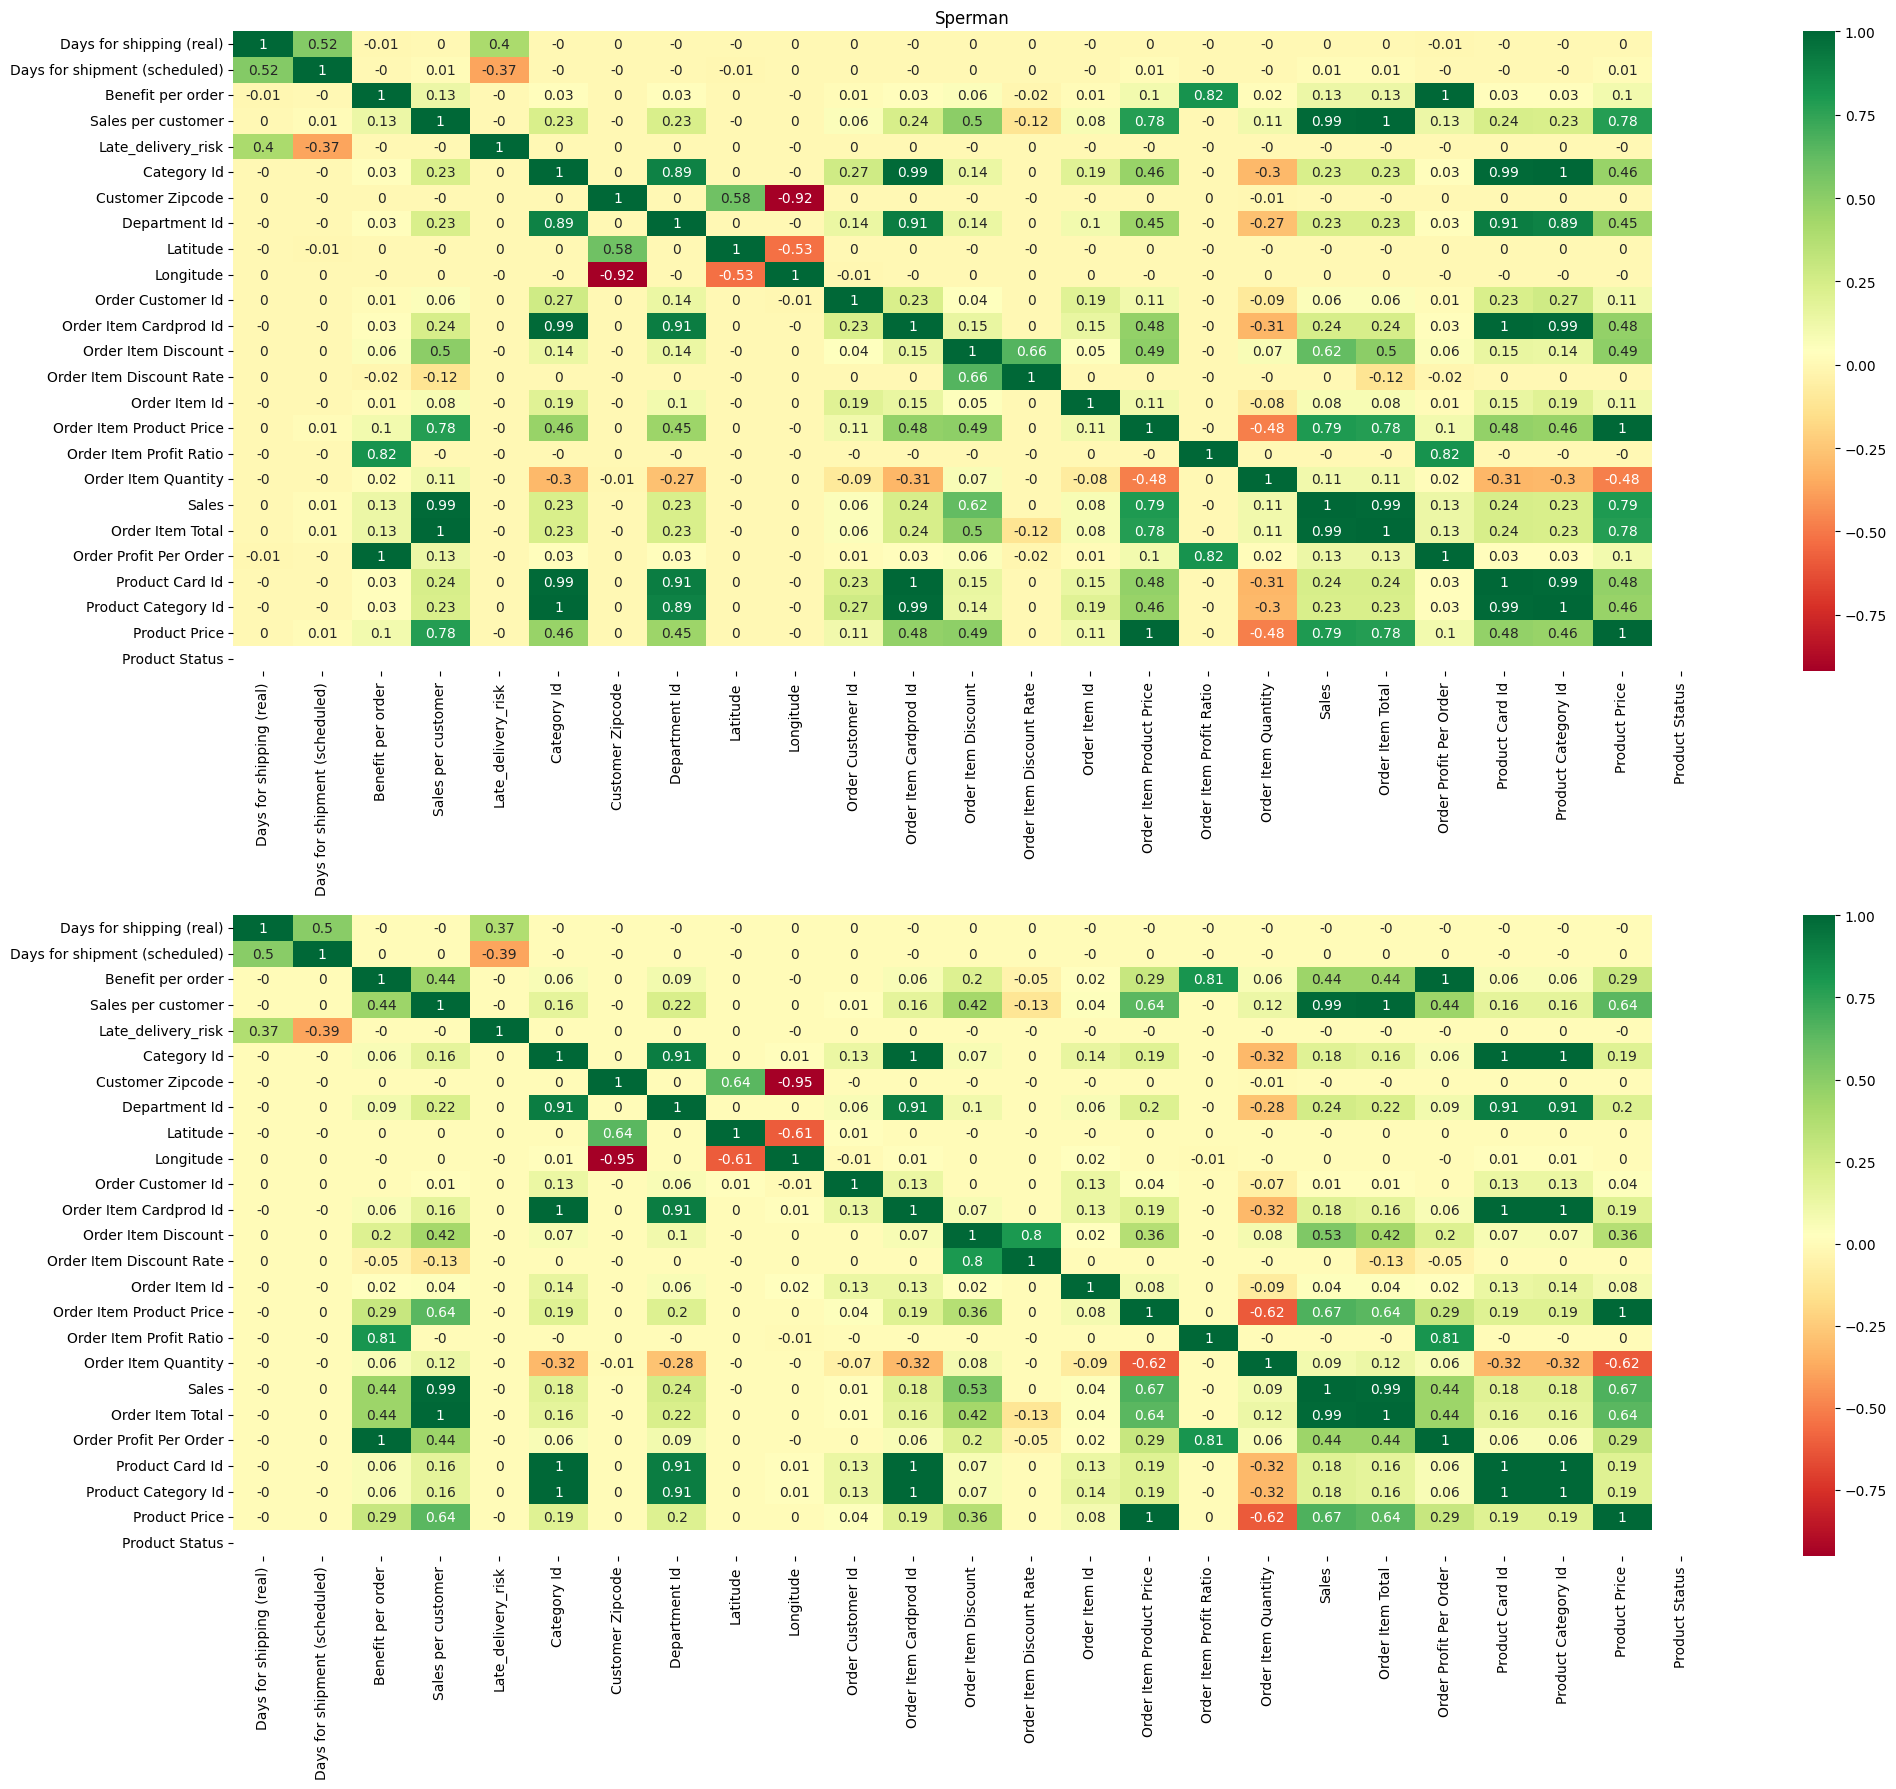

In [22]:
_, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (21, 18))

sns.heatmap(df[numerical_cols].corr().round(2), annot = True, ax = axes[0], cmap="RdYlGn")
sns.heatmap(df[numerical_cols].corr(method = 'spearman').round(2), annot = True, ax = axes[1], cmap="RdYlGn")
axes[0].set_title('Pearson')
axes[0].set_title('Sperman')
plt.tight_layout()
plt.show()

**Korelasi Pearson**:
- Order Item Total (0.99): Penjualan naik seiring total item yang dipesan.
- Order Item Profit Per Order (0.82): Keuntungan berbanding lurus dengan total penjualan.
- Late Delivery Risk dengan Longitude (-0.37): Mungkin dipengaruhi oleh lokasi geografis.
- Sales dengan Latitude (0.01).

**Korelasi Spearman**:
- Sales Korelasi tinggi dengan Order Item Total (0.99) dan Order Item Quantity (0.79).
- Late Delivery Risk: Korelasi negatif dengan Department Id (-0.27): Departemen tertentu lebih jarang mengalami risiko keterlambatan.
- Order Item Discount Rate: Korelasi positif kecil dengan Order Item Quantity (0.08): Diskon memengaruhi jumlah pesanan.

### Dropdown

**Dropdown kolom yang tidak dibutuhkan**

In [23]:
drop_cols = ['Order Profit Per Order', 'Sales per customer', 'Order Item Total', 'Department Id', 
             'Order Item Cardprod Id', 'Product Category Id', 'Product Card Id', 'Order Customer Id', 
             'Order Item Product Price', 'Product Status']
df.drop(columns = drop_cols,  inplace = True)

### Shipment Disparity

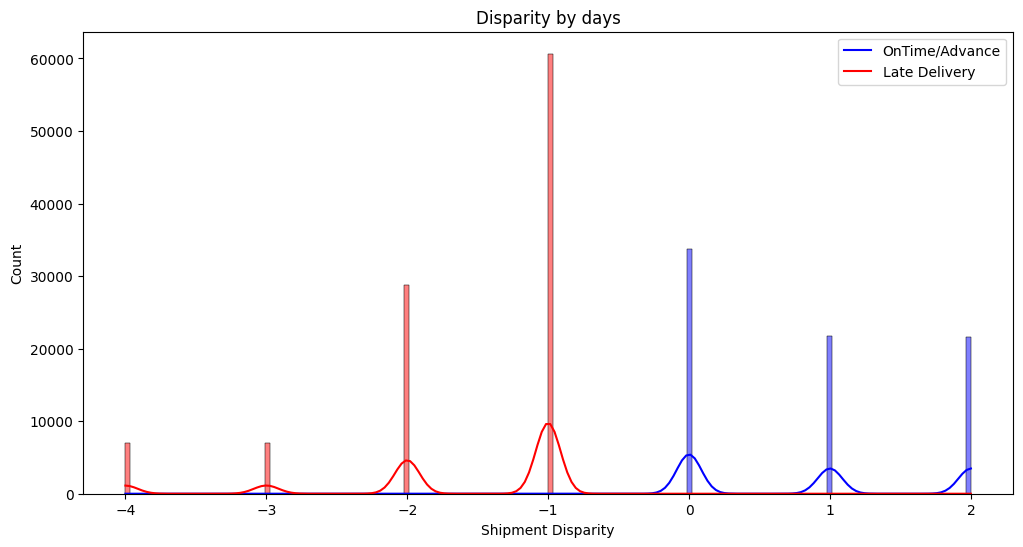

In [24]:
dd = pd.DataFrame()
plt.figure(figsize = (12, 6))
dd['Shipment Disparity'] = df['Days for shipment (scheduled)'] - df['Days for shipping (real)']
palette = {True: 'blue', False: 'red'}
plot = sns.histplot(data = dd, x = 'Shipment Disparity', kde = True, hue=dd['Shipment Disparity'] >= 0, palette=palette)
plot.legend(['OnTime/Advance', 'Late Delivery'])
plt.title('Disparity by days')
plt.show()

**Pada gambar diatas ditampilkan jumlah pengirimam yang tepat waktu dan yang terlambat**
- Berdasarkan jadwal puncak keterlambatan -1 hari
- Mayoritas tepat waktu
- Pengiriman Lebih Cepat Jarang Terjadi
- Keterlambatan Ekstrem Jarang, keterlambatan yang lebih dari 2 hari (-3 atau -4 hari) sangat jarang terjadi.
- Tidak ada disparitas besar dalam jadwal pengiriman, menandakan kontrol logistik yang konsisten.

### Benefit per order

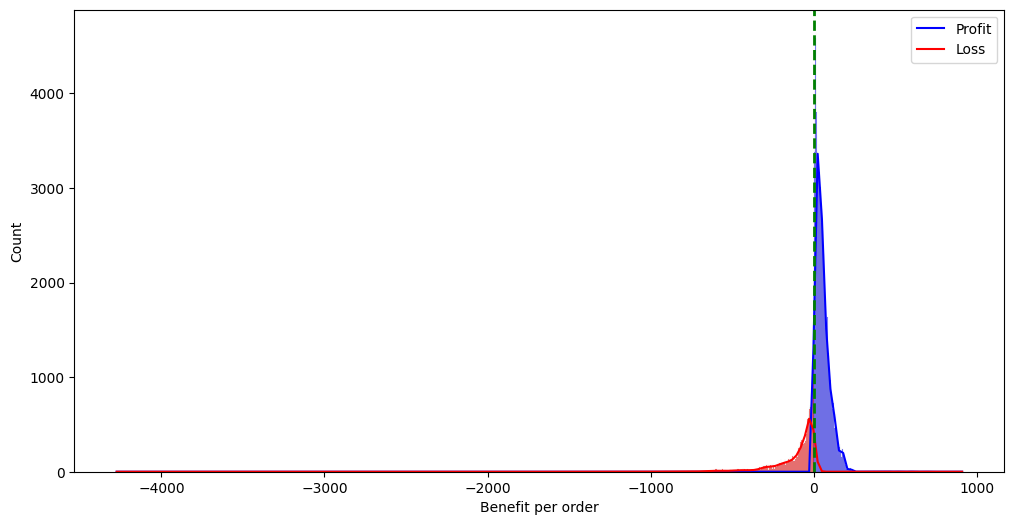

In [25]:
plt.figure(figsize = (12, 6))
palette = {True: 'blue', False: 'red'}
plot = sns.histplot(data = df, x = 'Benefit per order', kde = True, hue=df['Benefit per order'] > 0, palette=palette)
plt.axvline(0, color='green', linestyle='--', linewidth=2)
plot.legend(['Profit', 'Loss'])
plt.show()

**Pada gambar diatas ditampilkan distribusi "Benefit per Order", yaitu keuntungan atau kerugian yang dihasilkan dari setiap pesanan**
- **Keuntungan Dominan Tapi Kecil**: Sebagian besar pesanan menghasilkan keuntungan kecil, yang mengindikasikan margin keuntungan per pesanan cukup rendah.
- **Kerugian Minor Cukup Umum**: Kerugian kecil (di dekat 0) cukup sering terjadi, kemungkinan disebabkan oleh biaya operasional atau faktor lain seperti diskon atau kesalahan estimasi biaya.
- **Kerugian Besar Perlu Diwaspadai**: Outlier kerugian besar menunjukkan adanya kasus pesanan yang sangat tidak menguntungkan. Ini perlu dianalisis lebih lanjut untuk menemukan penyebabnya, misalnya kesalahan harga atau biaya pengiriman yang tinggi.
- **Peluang Peningkatan Margin**: Fokus pada strategi untuk meningkatkan margin keuntungan per pesanan dapat membantu profitabilitas keseluruhan, misalnya melalui efisiensi logistik atau optimasi harga.


### Order Item Profit Ratio

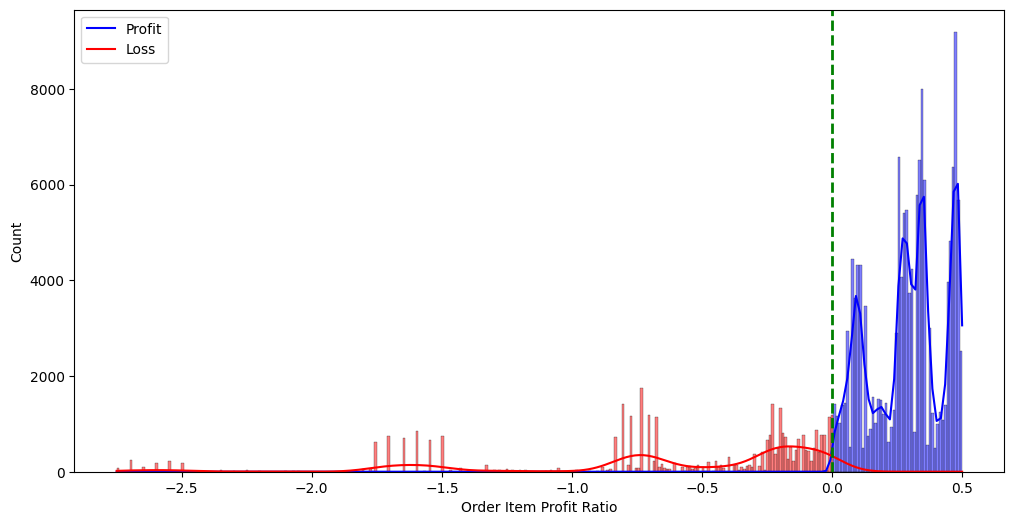

In [26]:
plt.figure(figsize = (12, 6))
palette = {True: 'blue', False: 'red'}
plot = sns.histplot(data = df, x = 'Order Item Profit Ratio', kde = True, hue=df['Order Item Profit Ratio'] > 0, palette=palette)
plt.axvline(0, color='green', linestyle='--', linewidth=2)
plot.legend(['Profit', 'Loss'])
plt.show()

**Pada gambar diatas ditampilkan visualisasi distribusi Order Item Profit Ratio**

- **Profit vs Loss Distribution**: Sebagian besar nilai Order Item Profit Ratio berada di sisi positif (Profit), yang berarti sebagian besar transaksi menghasilkan keuntungan. Terdapat beberapa transaksi dengan nilai negatif (Loss), tetapi frekuensinya jauh lebih kecil dibandingkan transaksi yang menguntungkan.
- **Pola Profit**: Profit memiliki puncak distribusi yang jelas dengan nilai yang cenderung berkumpul dekat dengan angka tertentu di sisi kanan dari garis 0.
Distribusi keuntungan lebih terpusat dan signifikan dibandingkan distribusi kerugian.
- **Pola Loss**: Loss memiliki distribusi yang tersebar luas di sisi negatif, dengan beberapa transaksi memiliki rasio profit negatif yang besar.
- **Dominasi Profit**: Distribusi Order Item Profit Ratio menunjukkan transaksi lebih banyak menghasilkan profit dibandingkan loss.

### Category Id

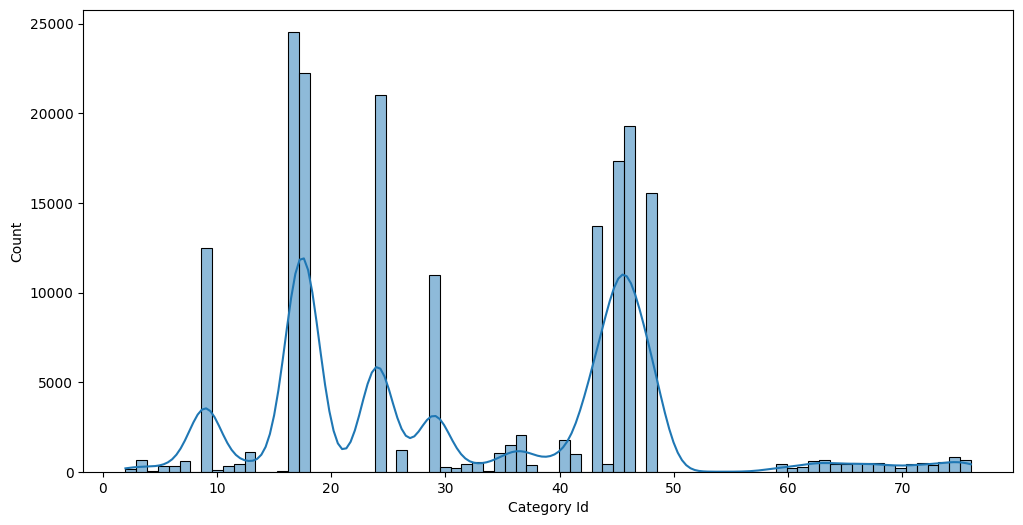

In [27]:
plt.figure(figsize = (12, 6))
plot = sns.histplot(data = df, x = 'Category Id', kde = True)
plt.show()

**Pada Gambar ini ditampilkan kernel density estimation (KDE) yang menggambarkan distribusi Category Id**
* **Kategori Dominan**: Beberapa kategori (contoh: sekitar Id 20, 40, dan 50) memiliki jumlah data yang jauh lebih banyak dibanding kategori lainnya.
Hal ini menunjukkan kategori-kategori tersebut lebih sering muncul dalam dataset.
* **Pola Distribusi**: Distribusi data tidak merata; sebagian besar data terkonsentrasi pada beberapa kategori saja.
Ada jeda atau gap antara kelompok kategori tertentu, menunjukkan beberapa kategori jarang muncul atau bahkan tidak ada sama sekali.
* **Long Tail**: Beberapa kategori memiliki frekuensi sangat kecil (di area kanan, seperti Id > 60), yang menunjukkan adanya kategori yang jarang digunakan.

### Order Item Discount

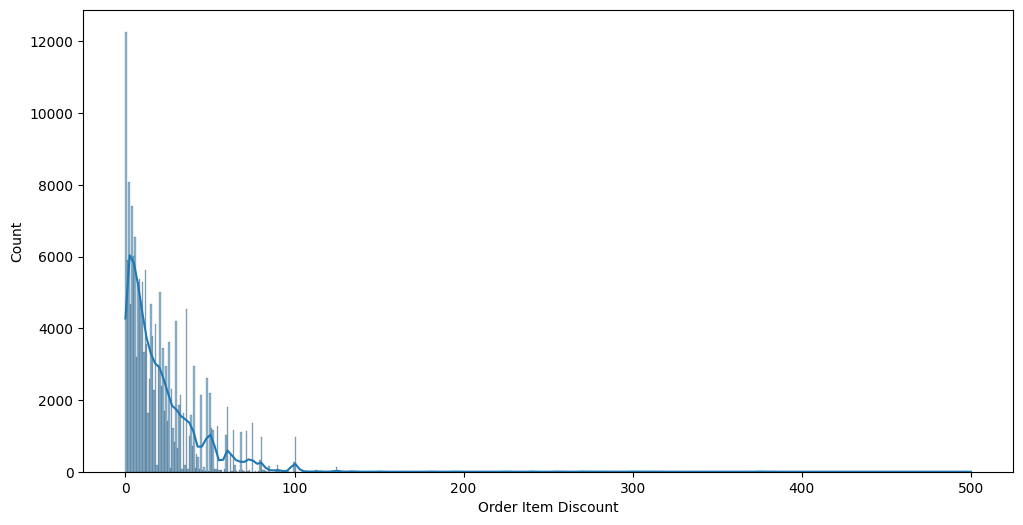

In [28]:
plt.figure(figsize = (12, 6))
plot = sns.histplot(data = df, x = 'Order Item Discount', kde = True)
plt.show()

**Pada Gambar ini ditampilkan menunjukkan distribusi Order Item Discount**
- **Diskon Rendah Mendominasi**: Sebagian besar item dijual dengan diskon kecil (di bawah 50), menunjukkan bahwa diskon besar jarang diberikan dan lebih banyak penjualan terjadi tanpa potongan harga signifikan.
- **Distribusi Tidak Simetris**: Distribusi condong ke kiri (skewed to the left), menandakan bahwa diskon tinggi adalah kejadian langka. Sebaliknya, diskon rendah memiliki frekuensi yang sangat tinggi.
- **Keberadaan Outlier**: Terdapat beberapa transaksi dengan diskon sangat besar (di atas 200 hingga 500), yang perlu ditinjau lebih lanjut karena bisa menjadi promosi khusus atau data outlier.
- **Pola Diskon untuk Strategi**: Pola ini dapat memberikan wawasan bahwa strategi diskon lebih sering digunakan pada tingkat rendah, mungkin untuk menjaga profit margin atau menarik pembeli tanpa mengorbankan terlalu banyak pendapatan.

### Order Item Discount Rate

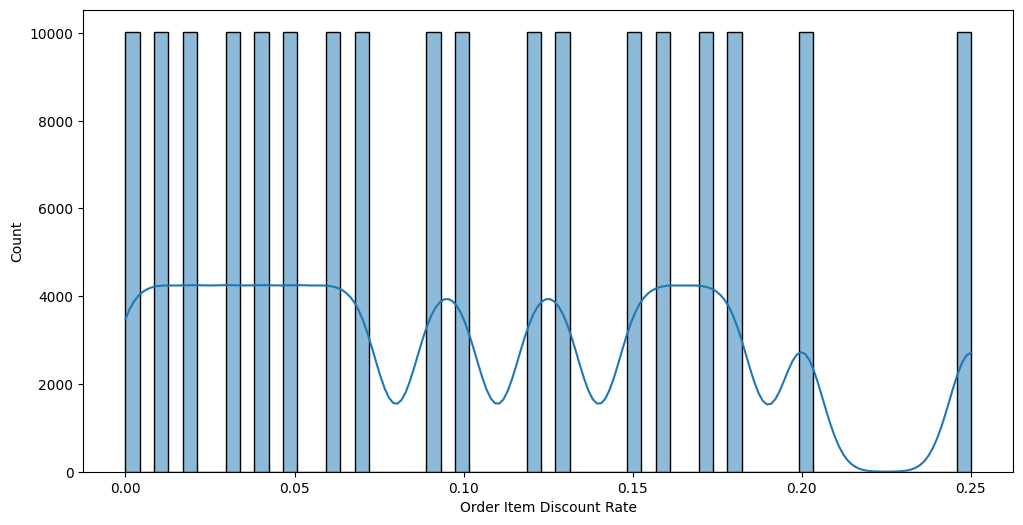

In [29]:
plt.figure(figsize = (12, 6))
plot = sns.histplot(data = df, x = 'Order Item Discount Rate', kde = True)
plt.show()

**Pada Gambar ini ditampilkan menunjukkan Order Item Discount Rate.**
- Diskon pada item pesanan diberikan pada nilai diskret tertentu (misalnya, 0%, 5%, 10%, dll.).
- Penggunaan KDE pada data diskret seperti ini tidak memberikan wawasan yang berarti karena KDE lebih cocok untuk data kontinu.

### Order Item Quantity

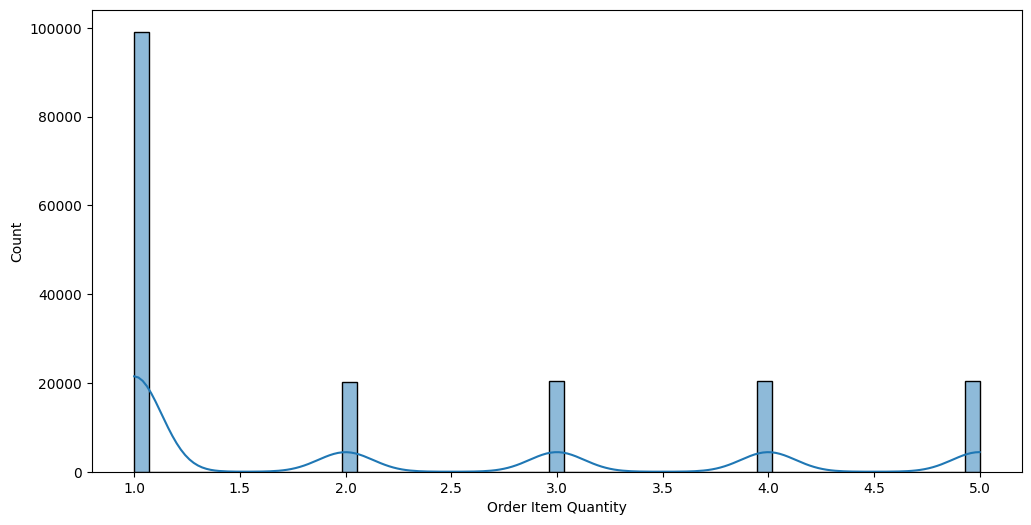

In [30]:
plt.figure(figsize = (12, 6))
plot = sns.histplot(data = df, x = 'Order Item Quantity', kde = True)
plt.show()

**Pada Gambar ini ditampilkan menunjukkan Order Item Quantity**
- Mayoritas pesanan hanya terdiri dari 1 item, yang menunjukkan bahwa pelanggan cenderung membeli dalam jumlah kecil.
- Kuantitas pesanan lebih dari 1 jarang terjadi, dan semakin sedikit pesanan dengan jumlah yang lebih besar.
- Distribusi ini dapat mencerminkan perilaku pelanggan atau sifat produk yang dijual (misalnya, barang satuan yang tidak memerlukan pembelian dalam jumlah besar).

### Sales

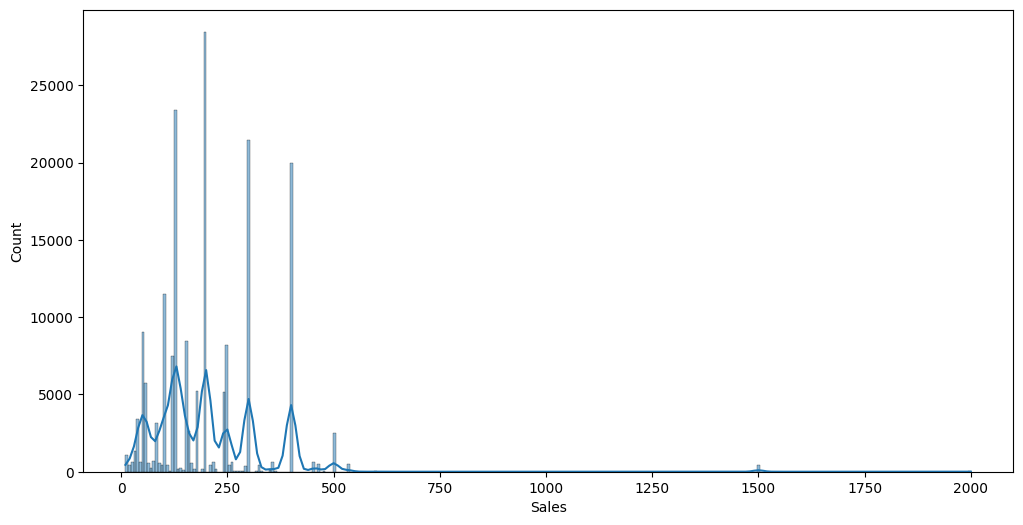

In [31]:
plt.figure(figsize = (12, 6))
plot = sns.histplot(data = df, x = 'Sales', kde = True)
plt.show()

**Pada Gambar ini ditampilkanc Sales**
- Sebagian besar transaksi memiliki nilai penjualan rendah (di bawah 300), yang mungkin menunjukkan mayoritas produk yang dijual memiliki harga rendah atau pembelian dalam jumlah kecil.
- Ada transaksi dengan nilai penjualan tinggi, tetapi ini jarang terjadi.
- Distribusi penjualan memiliki ekor panjang ke kanan, yang khas untuk data finansial, karena beberapa transaksi besar dapat memengaruhi total penjualan secara signifikan.

### Product Price

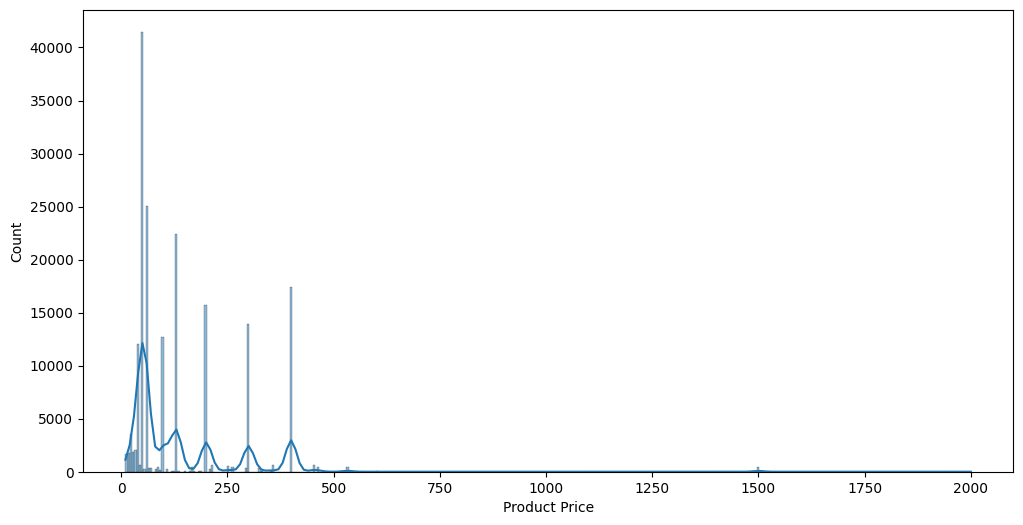

In [32]:
plt.figure(figsize = (12, 6))
plot = sns.histplot(data = df, x = 'Product Price', kde = True)
plt.show()

**Pada Gambar ini ditampilkan Product Price**
- Sebaran Asimetris: Data harga produk menunjukkan distribusi yang sangat tidak merata dan condong ke kiri (skewed left). Sebagian besar harga produk berada di kisaran rendah (di bawah 250).
- Produk Murah Lebih Dominan: Hal ini mengindikasikan bahwa sebagian besar produk memiliki harga yang murah, dengan hanya sedikit produk yang memiliki harga tinggi.
- Distribusi Tidak Normal: Garis KDE menunjukkan distribusi tidak simetris, dengan ekor panjang di bagian harga yang lebih tinggi.

# Feature Engineering 

In [33]:
df['order_year'] = pd.DatetimeIndex(df['order date (DateOrders)']).year
df['order_month'] = pd.DatetimeIndex(df['order date (DateOrders)']).month
df['order_day'] = pd.DatetimeIndex(df['order date (DateOrders)']).day
df['shipping_year'] = pd.DatetimeIndex(df['shipping date (DateOrders)']).year
df['shipping_month'] = pd.DatetimeIndex(df['shipping date (DateOrders)']).month
df['shipping_day'] = pd.DatetimeIndex(df['shipping date (DateOrders)']).day

In [34]:
df.drop(columns = ['order date (DateOrders)', 'shipping date (DateOrders)', 'Category Name'], inplace = True)
df.head()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Delivery Status,Late_delivery_risk,Category Id,Customer Segment,Customer Zipcode,Department Name,Latitude,Longitude,Order City,Order Country,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Profit Ratio,Order Item Quantity,Sales,Order State,Order Status,Product Price,Shipping Mode,order_year,order_month,order_day,shipping_year,shipping_month,shipping_day
0,DEBIT,3,4,91.250000,Advance shipping,0,73,Consumer,725.0,Fitness,18.251453,-66.037056,Bekasi,Indonesia,13.110000,0.04,180517,0.29,1,327.75,Java Occidental,COMPLETE,327.75,Standard Class,2018,1,31,2018,2,3
1,TRANSFER,5,4,-249.089996,Late delivery,1,73,Consumer,725.0,Fitness,18.279451,-66.037064,Bikaner,India,16.389999,0.05,179254,-0.80,1,327.75,Rajastán,PENDING,327.75,Standard Class,2018,1,13,2018,1,18
2,CASH,4,4,-247.779999,Shipping on time,0,73,Consumer,95125.0,Fitness,37.292233,-121.881279,Bikaner,India,18.030001,0.06,179253,-0.80,1,327.75,Rajastán,CLOSED,327.75,Standard Class,2018,1,13,2018,1,17
3,DEBIT,3,4,22.860001,Advance shipping,0,73,Home Office,90027.0,Fitness,34.125946,-118.291016,Townsville,Australia,22.940001,0.07,179252,0.08,1,327.75,Queensland,COMPLETE,327.75,Standard Class,2018,1,13,2018,1,16
4,PAYMENT,2,4,134.210007,Advance shipping,0,73,Corporate,725.0,Fitness,18.253769,-66.037048,Townsville,Australia,29.500000,0.09,179251,0.45,1,327.75,Queensland,PENDING_PAYMENT,327.75,Standard Class,2018,1,13,2018,1,15


In [35]:
df = pd.get_dummies(df)
print(df.shape)
df.head()

(180516, 4906)


Days for shipping (real)  Days for shipment (scheduled)  Benefit per order  \
0                         3                              4          91.250000   
1                         5                              4        -249.089996   
2                         4                              4        -247.779999   
3                         3                              4          22.860001   
4                         2                              4         134.210007   

   Late_delivery_risk  Category Id  Customer Zipcode   Latitude   Longitude  \
0                   0           73             725.0  18.251453  -66.037056   
1                   1           73             725.0  18.279451  -66.037064   
2                   0           73           95125.0  37.292233 -121.881279   
3                   0           73           90027.0  34.125946 -118.291016   
4                   0           73             725.0  18.253769  -66.037048   

   Order Item Discount  Order Item Discount Rate  Order Item Id  \
0            13.110000                      0.04         180517   
1            16.389999                      0.05         179254   
2            18.030001                      0.06         179253   
3            22.940001                      0.07         179252   
4            29.500000                      0.09         179251   

   Order Item Profit Ratio  Order Item Quantity   Sales  Product Price  \
0                     0.29                    1  327.75         327.75   
1                    -0.80                    1  327.75         327.75   
2                    -0.80                    1  327.75         327.75   
3                     0.08                    1  327.75         327.75   
4                     0.45                    1  327.75         327.75   

   order_year  order_month  order_day  shipping_year  shipping_month  \
0        2018            1         31           2018               2   
1        2018            1         13           2018               1   
2        2018            1         13           2018               1   
3        2018            1         13           2018               1   
4        2018            1         13           2018               1   

   shipping_day  Type_CASH  Type_DEBIT  Type_PAYMENT  Type_TRANSFER  \
0             3      False        True         False          False   
1            18      False       False         False           True   
2            17       True       False         False          False   
3            16      False        True         False          False   
4            15      False       False          True          False   

   Delivery Status_Advance shipping  Delivery Status_Late delivery  \
0                              True                          False   
1                             False                           True   
2                             False                          False   
3                              True                          False   
4                              True                          False   

   Delivery Status_Shipping canceled  Delivery Status_Shipping on time  \
0                              False                             False   
1                              False                             False   
2                              False                              True   
3                              False                             False   
4                              False                             False   

   Customer Segment_Consumer  Customer Segment_Corporate  \
0                       True                       False   
1                       True                       False   
2                       True                       False   
3                      False                       False   
4                      False                        True   

   Customer Segment_Home Office  Department Name_Apparel  \
0                         False               

In [36]:
X = df.drop(['Days for shipping (real)','Days for shipment (scheduled)'], axis=1)
y = df[['Days for shipping (real)','Days for shipment (scheduled)']]
X.shape, y.shape

((180516, 4904), (180516, 2))

# Pembuatan Model

## Decision Tree

In [37]:
import sklearn
print(sklearn.__version__)

1.2.2


In [38]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
model = DecisionTreeRegressor(random_state=42, max_depth=5)  # Sesuaikan max_depth jika diperlukan

In [41]:
model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, random_state=42)

In [42]:
# Prediksi pada data uji
y_pred = model.predict(X_test)

# Hitung metrik evaluasi
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)


Mean Squared Error (MSE): 0.18369129588384553
Mean Absolute Error (MAE): 0.20962950474102005


In [43]:
def metrics(y_test,pred):
    a =r2_score(y_test,pred)
    b =mean_squared_error(y_test,pred)
    c =mean_absolute_error(y_test,pred)
    print('The r-squared score of the model is ',round(a, 2))
    print('The mean squared error is',round(b, 2))
    print('The mean accuracy score is',round(c, 2))
    
metrics(y_test, y_pred)

The r-squared score of the model is  0.93
The mean squared error is 0.18
The mean accuracy score is 0.21


# Hyperparameter Tunning

## Decision Tree

In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

In [45]:
param_grid = {
    'max_depth': [3, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

In [46]:
model = DecisionTreeRegressor(random_state=42)

In [47]:
grid_search = GridSearchCV(estimator=model, 
                           param_grid=param_grid, 
                           cv=5,  # 5-fold cross-validation
                           scoring='neg_mean_squared_error', 
                           verbose=1, 
                           n_jobs=-1)

In [48]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10, 20],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='neg_mean_squared_error', verbose=1)

In [49]:
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)  # Negatif karena `neg_mean_squared_error`

Best Parameters: {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best Score: 0.12070790718896836


In [50]:
best_model = grid_search.best_estimator_

# Prediksi pada data uji
y_pred = best_model.predict(X_test)

# Evaluasi ulang dengan model terbaik
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("MSE dengan Model Terbaik:", mse)
print("MAE dengan Model Terbaik:", mae)


MSE dengan Model Terbaik: 0.11656689575884056
MAE dengan Model Terbaik: 0.15204405065876686


In [51]:
def metrics(y_test,pred):
    a =r2_score(y_test,pred)
    b =mean_squared_error(y_test,pred)
    c =mean_absolute_error(y_test,pred)
    print('The r-squared score of the model is ',round(a, 2))
    print('The mean squared error is',round(b, 2))
    print('The mean accuracy score is',round(c, 2))
    
metrics(y_test, y_pred)

The r-squared score of the model is  0.96
The mean squared error is 0.12
The mean accuracy score is 0.15


# Save Model

In [56]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

import joblib

# Bagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Latih model
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

# Simpan model yang telah dilatih
joblib.dump(model, 'best_decision_tree_model(updated).pkl', protocol=4)
print("Model saved as 'best_decision_tree_model(updated).pkl'")


Model saved as 'best_decision_tree_model(updated).pkl'


In [55]:
import sklearn
print(sklearn.__version__)

1.2.2


In [68]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

# 1. Load Dataset
# Gantilah 'data.csv' dengan dataset Anda
data = pd.read_csv('/kaggle/input/dataco-smart-supply-chain-for-big-data-analysis/DataCoSupplyChainDataset.csv', encoding='ISO-8859-1')

# Pastikan kolom fitur dan target sesuai dengan dataset Anda
fitur_model = [
    'Days_for_shipping (real)',
    'Days_for_shipment_(scheduled)',
    'Shipping_Mode',
    'Customer_Segment',
    'Order_Item_Quantity',
    'Sales',
    'Order_Profit_Per_Order',
    'Late_delivery_risk'
]

# Normalisasi nama kolom untuk memastikan konsistensi
data.columns = data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

# 2. Pilih Fitur dan Target
X = data[[
    'days_for_shipping_real',
    'days_for_shipment_scheduled',
    'order_item_quantity',
    'sales',
    'order_profit_per_order'
]]  # Pilih kolom numerik
y = data['late_delivery_risk']  # Target prediksi


# 3. Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Latih Model
model = DecisionTreeRegressor(random_state=42, max_depth=5)  # Sesuaikan hyperparameter jika diperlukan
model.fit(X_train, y_train)

# 5. Evaluasi Model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Evaluasi Model:")
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared Score:", r2)

# 6. Simpan Model
joblib.dump(model, 'best_decision_tree_model(final).pkl', protocol=4)
print("Model saved as 'best_decision_tree_model.pkl'")


Evaluasi Model:
Mean Squared Error (MSE): 0.024072428129277425
Mean Absolute Error (MAE): 0.04736162402266903
R-squared Score: 0.9028020544394921
Model saved as 'best_decision_tree_model.pkl'
